**Collect Images Using OpenCV**

In [1]:
import cv2
import os
import time
import uuid #provides a way to generate and manipulate UUIDs (Universally Unique Identifiers)UUIDs are 128-bit values that are unique

In [2]:
image_path=os.path.join('E:\Detection','images')
number_of_images=10

In [128]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_of_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(image_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

**Review Dataset and Build Image Loading Function**

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
images = tf.data.Dataset.list_files('E:\Detection\images\\*.jpg')

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images = images.map(load_image)

In [20]:
images.as_numpy_iterator().next()

array([[[179, 167, 167],
        [176, 164, 164],
        [184, 170, 169],
        ...,
        [140, 137, 122],
        [153, 147, 135],
        [159, 153, 141]],

       [[186, 174, 174],
        [188, 177, 175],
        [193, 179, 178],
        ...,
        [145, 139, 127],
        [149, 142, 132],
        [152, 145, 135]],

       [[193, 179, 178],
        [190, 176, 175],
        [188, 174, 173],
        ...,
        [152, 145, 135],
        [151, 144, 136],
        [153, 146, 138]],

       ...,

       [[137, 133, 121],
        [140, 136, 124],
        [139, 136, 121],
        ...,
        [135, 127, 104],
        [134, 126, 103],
        [134, 126, 103]],

       [[133, 129, 117],
        [136, 132, 120],
        [138, 134, 122],
        ...,
        [139, 129, 104],
        [134, 126, 103],
        [131, 123, 100]],

       [[132, 128, 116],
        [135, 131, 119],
        [138, 134, 122],
        ...,
        [134, 124,  99],
        [133, 125, 102],
        [137, 129, 106]]

**View Raw Images with Matplotlib**

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

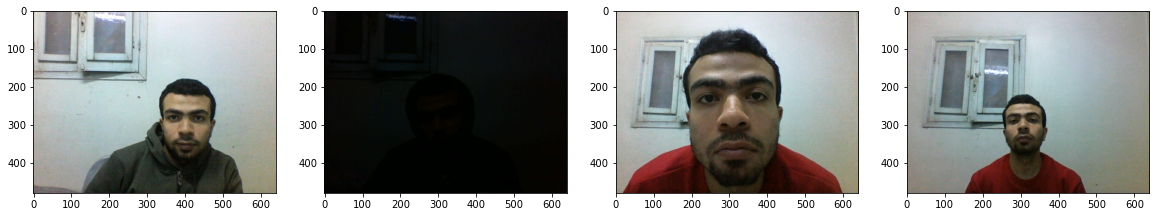

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

**-Partition Unaugmented Data**

**Move the Matching Labels**

In [11]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('E:\Detection', folder, 'image')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('E:\Detection','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('E:\Detection',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

**Load a Test Image and Annotation with OpenCV and JSON**

In [12]:
import albumentations as alb

In [13]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.2), 
                         alb.RandomBrightnessContrast(p=0.3),
                         alb.RandomGamma(p=0.3), 
                         alb.RGBShift(p=0.5), 
                         alb.VerticalFlip(p=0.2)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [14]:
img = cv2.imread(os.path.join('E:\Detection','train', 'image','f983f239-d75b-11ed-8cbd-5891cf6b11b9.jpg'))

with open(os.path.join('E:\Detection', 'train', 'labels', 'f983f239-d75b-11ed-8cbd-5891cf6b11b9.json'), 'r') as f:
    label = json.load(f)

label['shapes'][0]['points']

[[294.8730964467005, 177.56345177664977],
 [406.0406091370558, 303.9593908629442]]

In [15]:
label

{'version': '5.2.0',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[294.8730964467005, 177.56345177664977],
    [406.0406091370558, 303.9593908629442]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\f983f239-d75b-11ed-8cbd-5891cf6b11b9.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRo

**Extract Coordinates and Rescale to Match Image Resolution**

In [20]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[294.8730964467005, 177.56345177664977, 406.0406091370558, 303.9593908629442]

In [21]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.46073921319796957,
 0.36992385786802034,
 0.6344384517766497,
 0.6332487309644671]

**Apply Augmentations and View Results**

In [22]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [23]:
image_p='E:\Detection\train\image\7ae1ac93-d6d8-11ed-9b9c-5891cf6b11b9.jpg'
image_p.split('.')[0]
f'{image_p.split(".")[0]}.jpg'

'E:\\Detection\train\\image\x07ae1ac93-d6d8-11ed-9b9c-5891cf6b11b9.jpg'

In [29]:
augmented['bboxes']


[(0.14657642413987593,
  0.35680767061477725,
  0.39361534122955444,
  0.6376875352509871)]

In [30]:
augmented['bboxes'][0][2:]


(0.39361534122955444, 0.6376875352509871)

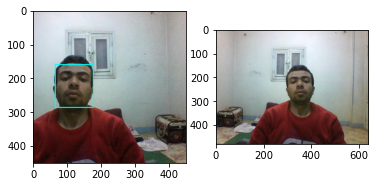

In [31]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,255,0), 2)
_,ax=plt.subplots(ncols=2)
ax[0].imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

**Run Augmentation Pipeline**

In [32]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('E:\Detection', partition, 'image')):
        img = cv2.imread(os.path.join('E:\Detection', partition, 'image', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('E:\Detection', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('E:\Detection\\agum', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('E:\Detection\\agum', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

**Load Augmented Images to Tensorflow Dataset**

In [6]:
train_images = tf.data.Dataset.list_files('E:\Detection\\agum\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [7]:
train_images.as_numpy_iterator().next()

array([[[0.76574755, 1.        , 0.9990809 ],
        [0.7563726 , 1.        , 0.9936274 ],
        [0.7465686 , 0.9966299 , 0.9995098 ],
        ...,
        [0.34234068, 0.7742034 , 0.9362745 ],
        [0.38069853, 0.80716914, 0.92512256],
        [0.40606618, 0.7744485 , 0.8933824 ]],

       [[0.6967524 , 0.98498774, 0.98137254],
        [0.7235294 , 0.9965686 , 0.99699754],
        [0.7175245 , 0.9714461 , 0.99460787],
        ...,
        [0.4672794 , 0.7957108 , 0.9783088 ],
        [0.5153799 , 0.83498776, 0.92518383],
        [0.7244485 , 0.99969363, 1.        ]],

       [[0.7104167 , 0.99767154, 0.9983456 ],
        [0.7325368 , 0.99987745, 0.99914217],
        [0.72022057, 0.97414213, 0.9898897 ],
        ...,
        [0.6610907 , 0.97365195, 0.9965686 ],
        [0.7268995 , 1.        , 0.9922794 ],
        [0.747549  , 0.99785537, 0.99852943]],

       ...,

       [[0.75980395, 1.        , 0.98970586],
        [0.7740196 , 1.        , 0.9965686 ],
        [0.7759804 , 1

In [8]:
test_images = tf.data.Dataset.list_files('E:\Detection\\agum\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [9]:
val_images = tf.data.Dataset.list_files('E:\Detection\\agum\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

**--Prepare Labels**

**Build Label Loading Function**

In [10]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

**Load Labels to Tensorflow Dataset**

In [11]:
train_labels = tf.data.Dataset.list_files('E:\Detection\\agum\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
test_labels = tf.data.Dataset.list_files('E:\Detection\\agum\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
val_labels = tf.data.Dataset.list_files('E:\Detection\\agum\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
train_labels.as_numpy_iterator().next()


(array([1], dtype=uint8),
 array([0.3157, 0.3604, 0.5435, 0.665 ], dtype=float16))

**--Combine Label and Image Samples**

In [15]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(2880, 2880, 660, 660, 600, 600)

**Create Final Datasets (Images/Labels)**

In [16]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [18]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [19]:
train.as_numpy_iterator().next()[0].shape


(8, 120, 120, 3)

**View Images and Annotations**

In [20]:
data_samples = train.as_numpy_iterator()

In [21]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


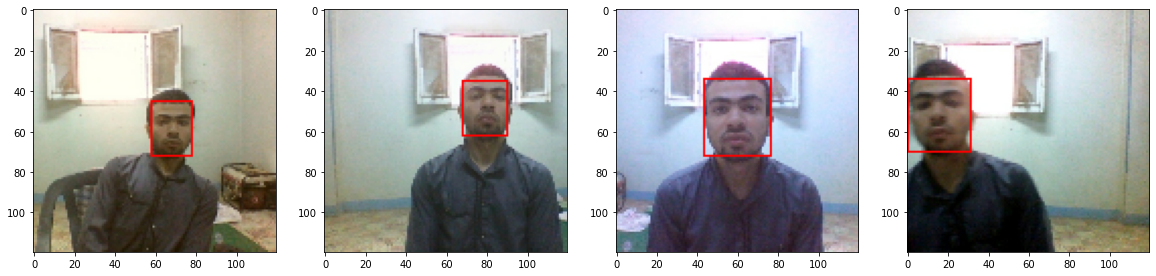

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0),1)

    ax[idx].imshow(sample_image)

## Build Deep Learning using the Functional API

**Import Layers and Base Network**

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

**Download VGG16**

In [24]:
vgg = VGG16(include_top=False)

In [25]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Build instance of Network**

In [26]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

**Test out Neural Network**

In [27]:
facetracker = build_model()

In [28]:
facetracker.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [29]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [30]:
ytrue=y[1]
ytrue[:,:4]

array([[0.5605, 0.382 , 0.6973, 0.542 ],
       [0.508 , 0.592 , 0.7886, 0.972 ],
       [0.345 , 0.0975, 0.788 , 0.7427],
       [0.1871, 0.0797, 0.6304, 0.725 ],
       [0.713 , 0.3882, 0.979 , 0.7896],
       [0.238 , 0.3909, 0.3948, 0.602 ],
       [0.553 , 0.3462, 0.7812, 0.651 ],
       [0.483 , 0.4   , 0.6196, 0.56  ]], dtype=float16)

In [31]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 2s 2s/step


(array([[0.644748  ],
        [0.5755095 ],
        [0.539752  ],
        [0.65024304],
        [0.5474286 ],
        [0.6031114 ],
        [0.5761007 ],
        [0.65812325]], dtype=float32),
 array([[0.6462983 , 0.614873  , 0.45483863, 0.4937341 ],
        [0.5627263 , 0.57067096, 0.4736774 , 0.48017818],
        [0.51599884, 0.6688285 , 0.4227415 , 0.44626892],
        [0.5183657 , 0.62438804, 0.4004391 , 0.3705275 ],
        [0.54617685, 0.617257  , 0.3933913 , 0.49074334],
        [0.5868052 , 0.61360043, 0.43009987, 0.42378792],
        [0.6196226 , 0.52834815, 0.38171512, 0.4675362 ],
        [0.59160346, 0.55276376, 0.3955478 , 0.5221518 ]], dtype=float32))

**Define Losses and Optimizers**

In [32]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

**Create Localization Loss and Classification Loss**

In [34]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return  delta_size+delta_coord

In [35]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

**Test out Loss Metrics**

In [36]:
localization_loss(y[1], coords).numpy()

5.0718307

In [37]:
classloss(y[0], classes).numpy()

0.5145576

## Train Neural Network

In [38]:
class FaceTracker(Model): 
    
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [39]:
model = FaceTracker(facetracker)

In [40]:
model.compile(opt, classloss, regressloss)

In [23]:
model=load_model('facetracker.h5')

**train**

In [24]:
hist = model.fit(train, epochs=26, validation_data=val)

NameError: name 'train' is not defined

**Plot Performance**

NameError: name 'hist' is not defined

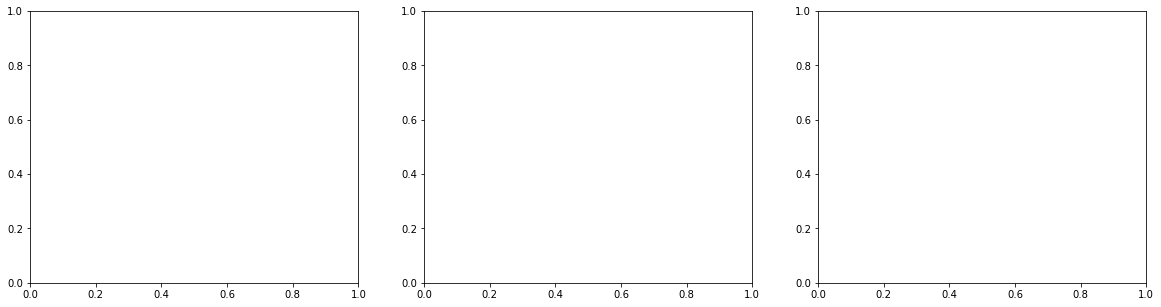

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

In [26]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

NameError: name 'test' is not defined

NameError: name 'test_sample' is not defined

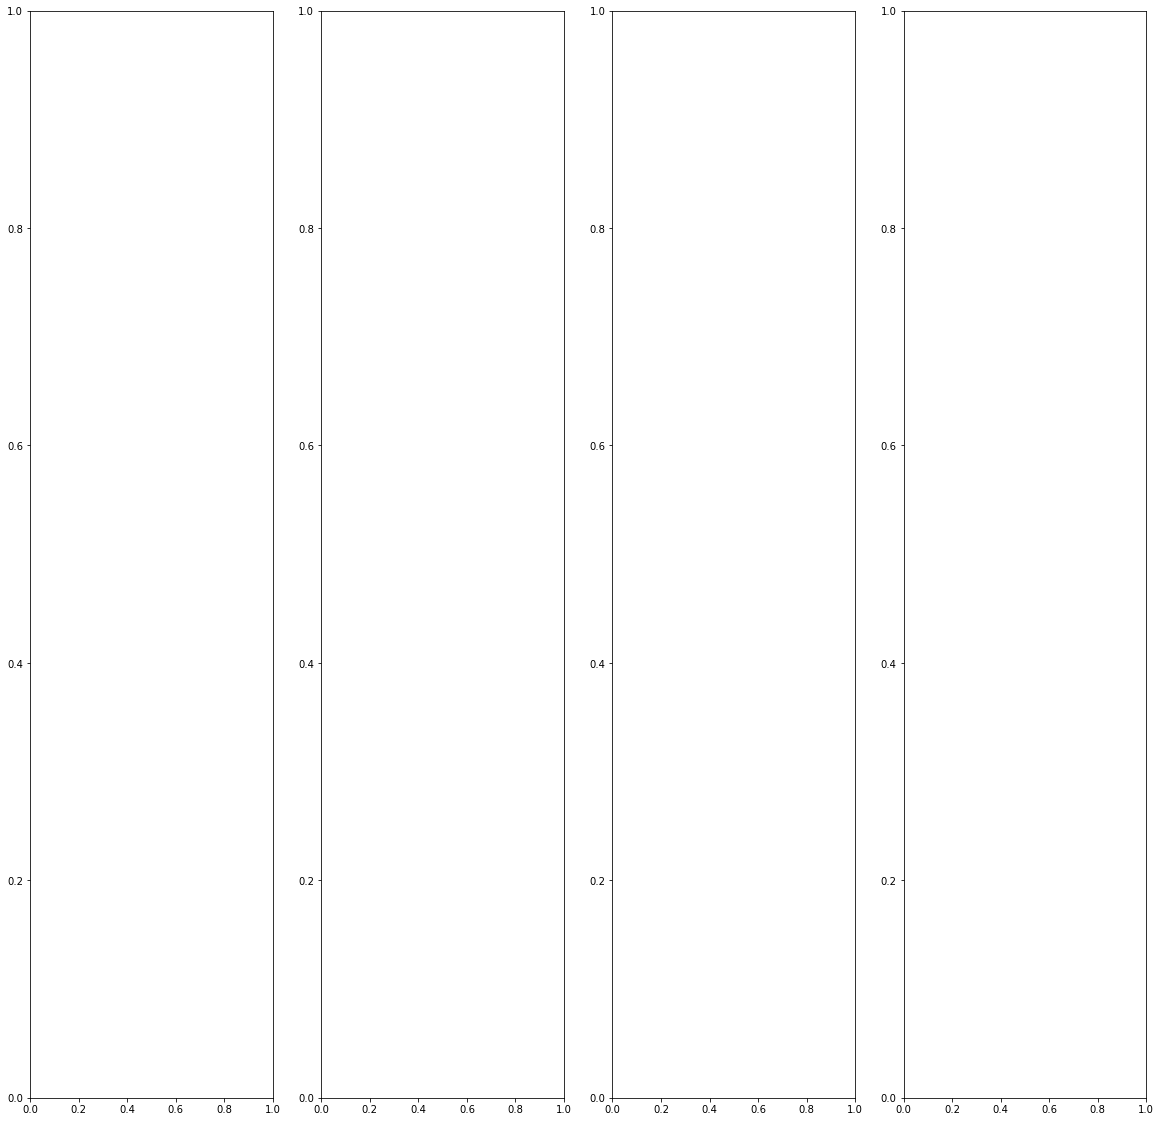

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

**Save the Model**

In [28]:
from tensorflow.keras.models import load_model

In [29]:
facetracker.save('facetracker.h5')

In [30]:
facetracker = load_model('E:\Detection\\facetracker (2).h5')

**Real Time Detection**

In [34]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 66ms/step


In [35]:
cap.release()
cv2.destroyAllWindows()